In [25]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib

In [26]:
pretrain_vgg16 = VGG16()

In [27]:
img = load_img('/content/bird.jpg', target_size=(224, 224))

# Convert image to array
img = img_to_array(img)

# Add batch to image shape 
img = np.expand_dims(img, 0) # (224, 224, 3) -> (1, 224, 224 ,3)

# Preprocess input 
img = preprocess_input(img)

In [28]:
predict = pretrain_vgg16.predict(img)
decode = decode_predictions(predict, top=2)[0]
print("Predict: ", decode)

1/1 [==============================] - 1s 737ms/step
Predict:  [('n01558993', 'robin', 0.9995433), ('n04604644', 'worm_fence', 0.00042212088)]


**Grad-CAM has three steps:**<br />
  * Compute Gradient of yᵪ with respect to the feature map activation Aᴷ of a convolutional layer
  * Global average pool the gradients over the width dimention and the height dimention αᴷᵪ
  * Perform a weighted conbination of the feature map activations Aᴷ

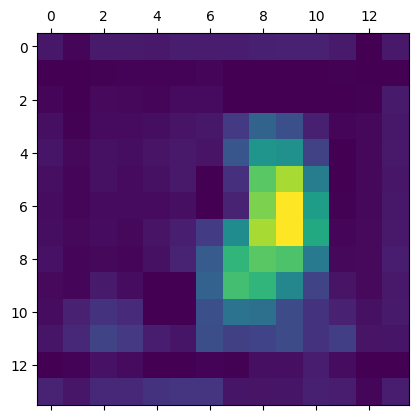

In [29]:
# The Grad-CAM
grad_model = keras.models.Model(inputs=pretrain_vgg16.input,
                                outputs=[pretrain_vgg16.get_layer('block5_conv3').output, pretrain_vgg16.output])
pred_index = None
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img)
    # Last_conv_layer_output: (1, 14, 14, 512)
    if pred_index is None:
        result = tf.math.top_k(preds[0], k=2)
        pred_index = result.indices.numpy()[0]
        # pred_index = tf.argmax(preds[0])
    
    class_channel = preds[:, pred_index]
# Gradient of the output with respect to the feature map. 
grads = tape.gradient(class_channel, last_conv_layer_output) 

# Mean intensity of the gradient over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) #(512, )

# How important this channel is
last_conv_layer_output = last_conv_layer_output[0] #(14, 14, 512)
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] # (14, 14, 512) @ (512, 1)
heatmap = tf.squeeze(heatmap) #(14, 14)

# Relu activation and normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
plt.matshow(heatmap.numpy())
plt.show()

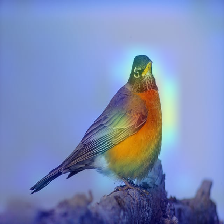

In [30]:
# Create a superimposed visualization
img = load_img('/content/bird.jpg', target_size=(224, 224))
img = img_to_array(img)

# Rescale heatmap to 0-255
heatmap = np.uint8(255*heatmap)
alpha = 0.4

# Use jet color map
jet = matplotlib.colormaps.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * alpha + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

display(superimposed_img)